# Lyric classifier

In [1]:
# https://www.kaggle.com/nolanbconaway/pitchfork-data

# scrape from genius
# https://chrishyland.github.io/scraping-from-genius/
# https://medium.com/analytics-vidhya/how-to-scrape-song-lyrics-a-gentle-python-tutorial-5b1d4ab351d2
import sqlite3
import pandas as pd

# import data
con = sqlite3.connect('pitchfork.sqlite')
genres = pd.read_sql('SELECT * FROM genres', con)
artists = pd.read_sql('SELECT * FROM artists', con)
reviews = pd.read_sql('SELECT * FROM reviews', con)
con.close()

scores = pd.concat([reviews['reviewid'], reviews['score']], axis=1)
albums = pd.concat([reviews['reviewid'], reviews['title']], axis=1)

genre_classes = genres['genre'].unique()
#genre_classes = ['None' if v is None else v for v in genre_classes]
genre_classes = [i for i in genre_classes if i]
print(genre_classes)

# combine genres and artists
data = pd.merge(pd.merge(pd.merge(genres, albums, on = 'reviewid'), artists, on='reviewid'), scores, on='reviewid') 

# remove 'various artists'
data = data[data.artist != 'various artists']

# remove None genre
data = data.dropna()

# sort by alphabetically by artist
data = data.sort_values(by=['score'], ascending=False)

df_train = data[0:15000]
df_test = data[15000:len(data)]
print(df_train)


['electronic', 'metal', 'rock', 'rap', 'experimental', 'pop/r&b', 'folk/country', 'jazz', 'global']
       reviewid         genre  \
18203      6200          rock   
3655      19182          rock   
1015      21866       pop/r&b   
5644      17064  experimental   
11272     12852       pop/r&b   
...         ...           ...   
365       22423  folk/country   
14369     10087           rap   
910       21868          rock   
9883      13988    electronic   
16109      7505          rock   

                                                 title            artist  \
18203  crooked rain, crooked rain: la's desert origins          pavement   
3655                                        spiderland             slint   
1015                                        dirty mind            prince   
5644                          the disintegration loops  william basinski   
11272                        histoire de melody nelson  serge gainsbourg   
...                                            

In [2]:
# generate files of artist-album from each genre

# init iterator 
it_genre = {}
num_artists = 100

# initialize empty genre.txt
for genre in genre_classes:
    if genre == 'pop/r&b':
        f = open("artist_album/pop-rnb.txt", "w+")
        f.close()
        it_genre['pop-rnb'] = num_artists
    elif genre == 'folk/country':
        f = open("artist_album/folk-country.txt", "w+")
        f.close()
        it_genre['folk-country'] = num_artists
    else:
        f = open("artist_album/"+genre+".txt", "w+")
        f.close()
        it_genre[genre] = num_artists
        
it_total = sum(it_genre.values())
# fill the genre.txt with artist_albums
for i, row in enumerate(data.itertuples()):
    if sum(it_genre.values()) != 0:
        if row.genre == 'pop/r&b':
            if it_genre['pop-rnb'] != 0:
                f = open("artist_album/pop-rnb.txt", "a+")
                f.write(row.artist + "_" + row.title + ";")
                f.close()
                it_genre['pop-rnb'] -= 1
        elif row.genre == 'folk/country':
            if it_genre['folk-country'] != 0:
                f = open("artist_album/folk-country.txt", "a+")
                f.write(row.artist + "_" + row.title + ";")
                f.close()
                it_genre['folk-country'] -= 1
        else:
            if it_genre[row.genre] != 0:
                f = open("artist_album/"+row.genre+".txt", "a+")
                f.write(row.artist + "_" + row.title + ";")
                f.close()
                it_genre[row.genre] -= 1
    else:
        break

In [3]:
import spacy 
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

def preprocess(text):
    # TODO: Replace the next line with your own code.
    output = []
    doc = nlp(text)
    for token in doc:
        if token.is_alpha and not token.is_stop:
            output.append(token.lemma_)
    return output

In [4]:
# read lyrics from files
import os

lyrics = []
genres = []

for filename in os.listdir('lyrics'):
    f = open(os.path.join('lyrics', filename), 'r')
    lyric = ""
    for line in f.readlines():
        if line != ";\n":
            lyric += line.replace('\n','') + ' '
        else:
            lyrics.append(lyric.lower())
            genres.append(filename[:-4])
            lyric = ""
    f.close()
    
# remove entries that are only whitespace
for i, val in enumerate(lyrics):
    if val.isspace():
        del lyrics[i]
        del genres[i]
        #print(i)

In [5]:
i = 3
print(genres[i], lyrics[i])



experimental when i look at you oh, i don't know what's real once in a while and you make me laugh and i'll sleep tomorrow and it won't be long once in a while then you take me down then you walk away when you say "i do" oh, i don't believe in you i can't forget it, ooh when you sleep tomorrow and it won't be long once in a while when you make me smile and you turn your long blonde hair when i look at you oh, i don't know what's real once in a while and you make me laugh and i'll sleep tomorrow and it won't be long once in a while then you take me down then you walk away 


In [6]:
import pandas as pd
# create pandas dataframe from lryics
df_lyrics = pd.DataFrame(list(zip(lyrics, genres)), columns = ['lyric', 'genre'])

# shuffle dataframe
df_lyrics = df_lyrics.sample(frac=1)

print(df_lyrics.head())

df_lyrics_train = df_lyrics[0:900]
df_lyrics_test = df_lyrics[901:1224]

#print(df_lyrics_train)
#print(df_lyrics_test)

                                                  lyric       genre
686   confessor of the tragedies in man lurking in t...       metal
1061  get a load of me, get a load of you walking do...        rock
840   new, new attitude but it's a shame, better tha...       metal
292   like a freshly cut diamond like a freshly cut ...         rap
437   you know this place you know this gloom? we've...  electronic


In [24]:
# undersample training data
nmin = df_lyrics_train['genre'].value_counts().min()
usdf_lyrics_train = df_lyrics_train.groupby('genre').apply(lambda x: x.sample(nmin)).reset_index(drop=True)

AxesSubplot(0.125,0.125;0.775x0.755)


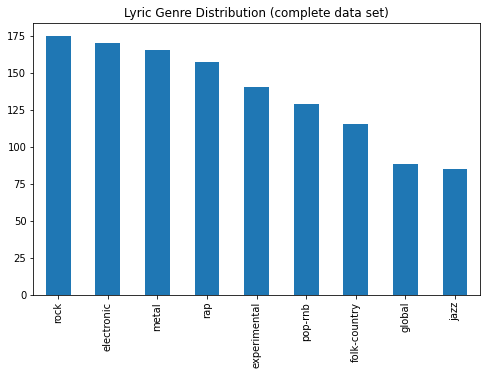

In [29]:
import matplotlib.pyplot as plt

print(df_lyrics['genre'].value_counts().plot(kind="bar", title="Lyric Genre Distribution (complete data set)", figsize=(8,5)))


In [9]:
from sklearn.metrics import classification_report

# Baseline classifiers

# random sampling, respecting class distribution
from sklearn.dummy import DummyClassifier
strat_dummy_clf = DummyClassifier(strategy = 'stratified')
strat_dummy_clf.fit(usdf_lyrics_train['lyric'], usdf_lyrics_train['genre'])
print(classification_report(y_true = df_lyrics_test['genre'], y_pred=strat_dummy_clf.predict(df_lyrics_test['lyric'])))

# random sampling, respecting class distribution
from sklearn.dummy import DummyClassifier
strat_dummy_clf = DummyClassifier(strategy = 'most_frequent')
strat_dummy_clf.fit(usdf_lyrics_train['lyric'], usdf_lyrics_train['genre'])
print(classification_report(y_true = df_lyrics_test['genre'], y_pred=strat_dummy_clf.predict(df_lyrics_test['lyric'])))

              precision    recall  f1-score   support

  electronic       0.13      0.15      0.14        39
experimental       0.16      0.10      0.12        52
folk-country       0.11      0.12      0.11        34
      global       0.08      0.15      0.11        20
        jazz       0.06      0.12      0.08        17
       metal       0.19      0.16      0.17        50
     pop-rnb       0.10      0.11      0.11        27
         rap       0.12      0.10      0.11        40
        rock       0.18      0.14      0.15        44

    accuracy                           0.13       323
   macro avg       0.13      0.13      0.12       323
weighted avg       0.14      0.13      0.13       323

              precision    recall  f1-score   support

  electronic       0.12      1.00      0.22        39
experimental       0.00      0.00      0.00        52
folk-country       0.00      0.00      0.00        34
      global       0.00      0.00      0.00        20
        jazz       0.00 

/courses/TDDE16/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# classifier (genre based on artist lyrics)
# count vectorizer & multinomial NB predictor
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

pipe1 = Pipeline([('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])
pipe1.fit(usdf_lyrics_train['lyric'], usdf_lyrics_train['genre'])
print(classification_report(y_true = df_lyrics_test['genre'], y_pred=pipe1.predict(df_lyrics_test['lyric'])))

              precision    recall  f1-score   support

  electronic       0.09      0.03      0.04        39
experimental       0.44      0.08      0.13        52
folk-country       0.67      0.06      0.11        34
      global       0.20      0.10      0.13        20
        jazz       0.50      0.06      0.11        17
       metal       0.29      0.04      0.07        50
     pop-rnb       0.11      0.41      0.17        27
         rap       0.22      0.85      0.35        40
        rock       0.18      0.09      0.12        44

    accuracy                           0.19       323
   macro avg       0.30      0.19      0.14       323
weighted avg       0.30      0.19      0.14       323



In [11]:
# classifier (genre based on artist lyrics)
# tfidf vectorizer & multionomial NB predictor

from sklearn.feature_extraction.text import TfidfVectorizer

pipe2 = Pipeline([('vectorizer', TfidfVectorizer()), ('nb', MultinomialNB())])
pipe2.fit(usdf_lyrics_train['lyric'], usdf_lyrics_train['genre'])
print(classification_report(y_true = df_lyrics_test['genre'], y_pred=pipe2.predict(df_lyrics_test['lyric'])))

              precision    recall  f1-score   support

  electronic       0.10      0.03      0.04        39
experimental       0.60      0.06      0.11        52
folk-country       0.38      0.09      0.14        34
      global       0.17      0.05      0.08        20
        jazz       0.00      0.00      0.00        17
       metal       0.00      0.00      0.00        50
     pop-rnb       0.14      0.26      0.18        27
         rap       0.16      0.93      0.28        40
        rock       0.21      0.07      0.10        44

    accuracy                           0.17       323
   macro avg       0.20      0.16      0.10       323
weighted avg       0.22      0.17      0.11       323



In [12]:
# classifier (genre based on artist lyrics)
# tfidf vectorizer & Multilayer Perceptron Classifier
from sklearn.neural_network import MLPClassifier

pipe3 = Pipeline([('vectorizer', TfidfVectorizer()), ('mlp', MLPClassifier(max_iter=400))])
pipe3.fit(usdf_lyrics_train['lyric'], usdf_lyrics_train['genre'])
print(classification_report(y_true = df_lyrics_test['genre'], y_pred=pipe3.predict(df_lyrics_test['lyric'])))



              precision    recall  f1-score   support

  electronic       0.14      0.13      0.14        39
experimental       0.26      0.19      0.22        52
folk-country       0.16      0.15      0.15        34
      global       0.14      0.20      0.16        20
        jazz       0.08      0.24      0.12        17
       metal       0.31      0.18      0.23        50
     pop-rnb       0.23      0.26      0.24        27
         rap       0.62      0.65      0.63        40
        rock       0.16      0.14      0.15        44

    accuracy                           0.24       323
   macro avg       0.23      0.24      0.23       323
weighted avg       0.25      0.24      0.24       323



In [13]:
# classifier (genre based on artist lyrics)
# tfidf vectorizer & suppoert vector machine
from sklearn import svm

pipe4 = Pipeline([('vectorizer', TfidfVectorizer()), ('svm', svm.SVC())])
pipe4.fit(usdf_lyrics_train['lyric'], usdf_lyrics_train['genre'])
print(classification_report(y_true = df_lyrics_test['genre'], y_pred=pipe4.predict(df_lyrics_test['lyric'])))

              precision    recall  f1-score   support

  electronic       0.11      0.05      0.07        39
experimental       0.40      0.08      0.13        52
folk-country       0.24      0.32      0.28        34
      global       0.16      0.30      0.21        20
        jazz       0.14      0.06      0.08        17
       metal       0.40      0.50      0.45        50
     pop-rnb       0.19      0.30      0.23        27
         rap       0.54      0.72      0.62        40
        rock       0.14      0.14      0.14        44

    accuracy                           0.28       323
   macro avg       0.26      0.27      0.24       323
weighted avg       0.28      0.28      0.26       323



In [14]:
# CV on SVC
from sklearn.model_selection import GridSearchCV
parameters = {'svm__kernel':['linear', 'rbf', 'poly', 'sigmoid'], 
              "vectorizer__binary" : [False, True], "vectorizer__ngram_range" : [(1,1), (1,2), (2,2)],
             "vectorizer__stop_words" : ['english', None], "svm__C" : [1, 1.5,1.6,1.7,1.8, 2]} 

print(pipe4.get_params().keys())

cv_classifier = GridSearchCV(pipe4, parameters) # by default: 5 fold CV
cv_classifier.fit(usdf_lyrics_train['lyric'], usdf_lyrics_train['genre'])

dict_keys(['memory', 'steps', 'verbose', 'vectorizer', 'svm', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__norm', 'vectorizer__preprocessor', 'vectorizer__smooth_idf', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__sublinear_tf', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__use_idf', 'vectorizer__vocabulary', 'svm__C', 'svm__break_ties', 'svm__cache_size', 'svm__class_weight', 'svm__coef0', 'svm__decision_function_shape', 'svm__degree', 'svm__gamma', 'svm__kernel', 'svm__max_iter', 'svm__probability', 'svm__random_state', 'svm__shrinking', 'svm__tol', 'svm__verbose'])


GridSearchCV(estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [1, 1.5, 1.6, 1.7, 1.8, 2],
                         'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                         'vectorizer__binary': [False, True],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'vectorizer__stop_words': ['english', None]})

In [15]:
#usdf_lyrics_train.to_numpy()
print(cv_classifier.best_params_)

print(classification_report(y_true = df_lyrics_test['genre'], y_pred=cv_classifier.best_estimator_.predict(df_lyrics_test['lyric'])))

{'svm__C': 1.5, 'svm__kernel': 'rbf', 'vectorizer__binary': True, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': None}
              precision    recall  f1-score   support

  electronic       0.00      0.00      0.00        39
experimental       0.33      0.12      0.17        52
folk-country       0.30      0.47      0.36        34
      global       0.25      0.30      0.27        20
        jazz       0.22      0.12      0.15        17
       metal       0.36      0.32      0.34        50
     pop-rnb       0.18      0.26      0.21        27
         rap       0.58      0.80      0.67        40
        rock       0.19      0.25      0.22        44

    accuracy                           0.30       323
   macro avg       0.27      0.29      0.27       323
weighted avg       0.28      0.30      0.27       323



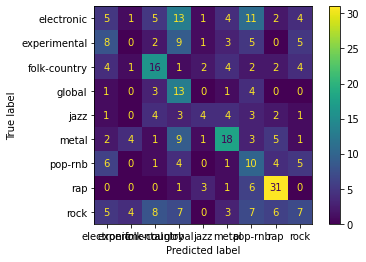

In [21]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(y_true=df_lyrics_test['genre'], y_pred=pipe1.predict(df_lyrics_test['lyric']))
#print(cm)

plot_confusion_matrix(pipe4, df_lyrics_test['lyric'], df_lyrics_test['genre'])


# Further analysis

{'electronic': 36.78823529411765, 'experimental': 40.892857142857146, 'folk-country': 48.77391304347826, 'global': 44.01136363636363, 'jazz': 59.64705882352941, 'metal': 48.76969696969697, 'pop-rnb': 42.15503875968992, 'rap': 91.08917197452229, 'rock': 41.17142857142857}
Counter({'rock': 175, 'electronic': 170, 'metal': 165, 'rap': 157, 'experimental': 140, 'pop-rnb': 129, 'folk-country': 115, 'global': 88, 'jazz': 85})


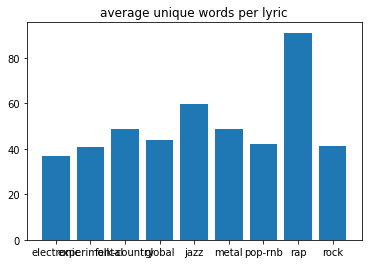

In [74]:
import matplotlib.pyplot as plt
import collections

# average amount of words
d = {'electronic': [], 'experimental' : [],
                     'folk-country' : [], 'global' : [],
                     'jazz' : [], 'metal' : [], 'pop-rnb' : [],
                     'rap' : [], 'rock' : []}


for lyric, genre in zip(lyrics, genres):
    d[genre].extend(set(lyric.lower().split()))
    
num = collections.Counter(genres)
for key in d.keys():
    d[key] = len(set(d[key])) / num[key]
    
print(d)
print(num)

plt.bar(d.keys(), d.values())
plt.title('average unique words per lyric')
plt.show()


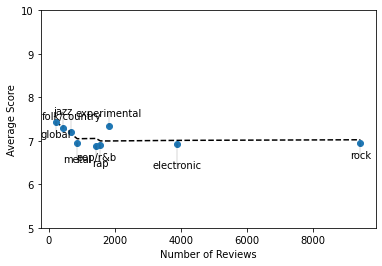

In [31]:
# review bias to genre?

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.signal import savgol_filter

pd.set_option('precision', 2)
np.set_printoptions(precision=2)

con = sqlite3.connect('pitchfork.sqlite')
reviews = pd.read_sql('SELECT * FROM reviews', con)
genres = pd.read_sql('SELECT * FROM genres', con)
con.close()


genre_data = pd.merge(reviews[['reviewid','score']], genres, 
                  on = 'reviewid')

g = genre_data.groupby('genre')
table = g['score'].agg(['count', 'mean', 'std']).reset_index()

# plot the average at each level of count
avgline = table.groupby('count')['mean'].mean().reset_index()
avgline['mean'] = savgol_filter(avgline['mean'], 5, 1)
plt.plot(avgline['count'], avgline['mean'],'k--')

plt.plot(table['count'],table['mean'],'o', alpha = 1)

for j, row in table.iterrows():
    curr_avg = float(avgline.loc[avgline['count'] == row['count'], 'mean'])
    jitter = np.random.uniform(0.1, high = 0.5)
    if row['mean'] < curr_avg: jitter*= -1.0
    
    plt.plot([row['count'], row['count']], [row['mean'], row['mean'] + jitter], 'k-', alpha = 0.1)
    plt.text(row['count'], row['mean'] + jitter, row['genre'], 
             ha = 'center', va = 'center')

plt.ylabel('Average Score')
plt.xlabel('Number of Reviews')
plt.ylim([5, 10])
plt.show()